In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import torch
import torch.nn as nn


In [10]:
#Data reading and splitting.
mnist_data = pd.read_csv('mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]

#random_state ensures that the split data is the same for each program iteration.
x_train, x_test, y_train, y_test = train_test_split(digits, labels, test_size=0.88, random_state=42)

In [11]:
#Donwsampling of data
def max_pooling_torch(digits, pool_size=2, stride=2, padding=0):
    digits_reshaped = digits.reshape(-1, 1, 28, 28)
    digits_tensor = torch.tensor(digits_reshaped, dtype=torch.float32)

    max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=stride, padding=padding)
    pooled_digits = max_pool(digits_tensor)
    pooled_digits = pooled_digits.view(pooled_digits.size(0), -1)

    pooled_digits = pooled_digits.numpy()

    return pooled_digits

x_train_pooled = max_pooling_torch(x_train)
x_test_pooled = max_pooling_torch(x_test)

<h3>Regularized multinomial logit model (using the LASSO penalty).</h3>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

The logistic regression classifier by default applies L2 (Ridge) regularisation using the lbfgs solver. The liblinear and the saga solver, support both L1 (Lasso) and L2 regularisation. Liblinear is used for one vs rest schemes, which is appropriate for digit classification. We initially explored the differences between the two solvers, and found that saga seemed to perform better, to validate this we added it to as a hyperparameter.

<h3>Initial Exploration</h3>

In [ ]:
logitClf = LogisticRegression(random_state=0, penalty="l1", solver="saga").fit(x_train,y_train)
logitClfLib = LogisticRegression(random_state=0, penalty="l1", solver="liblinear").fit(x_train,y_train)

In [ ]:
logitClf.score(x_train,y_train)

In [ ]:
logitClfLib.score(x_train,y_train)

<h3>K-Fold Cross Validation for Hyperparameter Tuning</h3>

We apply 5-fold cross validation to our models, and tune hyperparameters until the we hit diminishing returns (i.e not mutch change in mean cross validation error).
In a first round of hyperparameter tuning we used Cross Validation Grid search to apply 5-fold cross validation to all possible combinations of chosen parameters. The first round we tested five possible values for C [0.1,0.5,1,1.5,2] with the saga solver over 25 fits. The best fit was found at C=0.5 

In a second round, we added the solver as a hyperparameter with two options liblinear and saga and tested the following C values [0.3,0.4,0.5,0.6,0.7]. Where the best fit was present at 0.3 with the saga solver. (total of 50 fits) Yielding a crossvalidation accuracy of 88.6%

In a third round we tested the C-values [0.1,0.15,0.2,0.25,0.3,0.35] Here C=0.2 yielded the best result, which was rounded to 88.65, marginally better than for C=3. So we stopped tuning. And chose parameters C=0.2 and solver=saga.


In [3]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

In [ ]:

#Grid Search for parameter
#test 1 params = {'C': [0.1,0.5,1,1.5,2]} 
#test 2 params = {'C':  [0.3,0.4,0.5,0.6,0.7],'solver':["saga",'liblinear']}

params = {'C':  [0.1,0.15,0.2,0.25,0.3,0.35]}

best_logitComposition = GridSearchCV(estimator=logitClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_logitComposition.fit(x_train, y_train)

In [ ]:
best_logitComposition.best_params_

In [ ]:
best_logitComposition.best_score_

<h3>SVM Hyperparameter tuning</h3>
We use the same approach for hyperparameter tuning for the SVM, tuning using a 5-fold cross validation, tweaking the C value until we hit diminishing returns. 

Test 1: {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]} best C=2, cv accuracy: 0.886

Test 2: {'C':[1.5,1.7,1.9,2,2.2,2.4,2.5,2.8,3.0]} best {'C': 3} cv accuracy 0.955

Test 3: {'C':[3.0,3.5,4.0,4.5,5,5.5]} best {'C': 3.5} cv accuarcy 0.9561507936507937 (marginally better than Test 2 so we stop tuning)

Adding Hyperparameters Kernel and Gamma

Test 4: {'C':[1,3.0,3.5,4],'gamma':["scale", "auto"], "kernel":["linear","poly","rbf","sigmoid", "precomputed"]}

In [24]:
svmClf = SVC(gamma=1).fit(x_train,y_train)

In [5]:
svmClf.score(x_test,y_test)

0.11141774891774892

In [26]:
#test 1: params = {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]}
#test 2: params = {'C':[1.5,1.7,1.9,2,2.2,2.4,2.5,2.8,3.0]}
#params = {'C':[3.0,3.5,4.0,4.5,5,5.5]}
params= {'C':[1,3.0,3.5,4],'gamma':["scale", "auto"], "kernel":["linear","poly","rbf","sigmoid"]}
best_svmComposition = GridSearchCV(estimator=svmClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_svmComposition.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(gamma=1), n_jobs=-1,
             param_grid={'C': [1, 3.0, 3.5, 4], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=True)

In [27]:
best_svmComposition.best_params_

{'C': 3.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [11]:
best_svmComposition.best_score_

0.9561507936507937

<h3>Model Comparison</h3>

In the previous step we have determined the best values for hyperparameter C, which for both the LogisticRegression Classifier and the SupportVector Classifier signifies the inverse regularisation strenght, using a grid parameter search over a 5 fold cross validation. Smaller values, specify stronger regularisation. For the LogisticRegression Classifier we additionally determined the best solver.  

We continue with the following parameters:
LogisticRegression: C=0.2, solver=saga 
SVC: C=3.5

<h4>Final Logistic Model</h4>

In [12]:
finalLogitClf = LogisticRegression(random_state=0, C=0.2, penalty="l1", solver="saga").fit(x_train_pooled,y_train)

d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
finalLogitClf.score(x_test_pooled,y_test)

0.8831709956709957

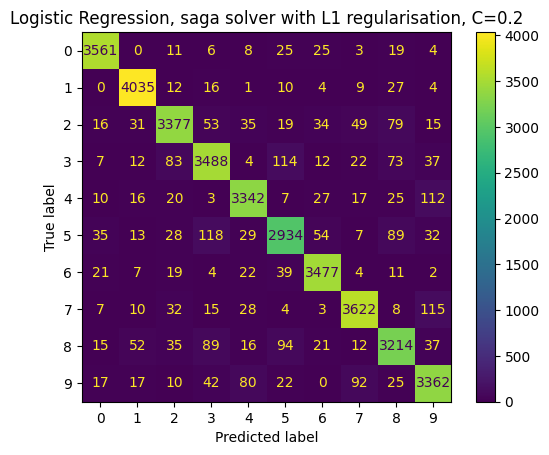

In [6]:
finalLogitPred = finalLogitClf.predict(x_test)
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression, saga solver with L1 regularisation, C=0.2")
plt.show()

<h4>Final SVM Model</h4>

In [14]:
finalSvmClf = SVC(gamma='scale',C=3.5).fit(x_train_pooled,y_train)

In [15]:
finalSvmClf.score(x_test_pooled,y_test)

0.955573593073593

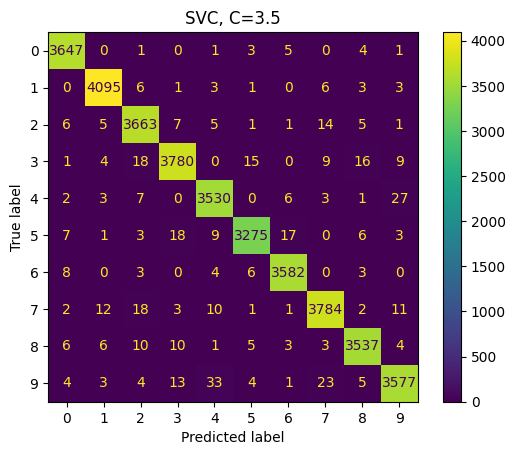

In [7]:
finalSvmPred = finalSvmClf.predict(x_test)
cm = confusion_matrix(y_test, finalSvmPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("SVC, C=3.5")
plt.show()

<h3>Evaluation</h3>
The results are in. For the SVM classifier we achieve accuracies of 95.7%  95.5 on downsampled data, on the test set.
For the Logistic Classifier we achieve 89.0% 88.3 on downsampled data accuracy. 

Now we check whether the differences are significant.

We are following the recommendations of Dietterichs 1998 paper on statistical testing for classification, and performing both the
paired 5x2CV test, and McNemar test. The 5x2CV test is recommended for our scenario using two efficient classifiers, while McNemar is more suitable for in cases
where many fits are not possible because of excessive trainig times (large DNNs). 

Paired ttest 5x2cv 
t statistic: 31.291
p value: 0.000

McNeimar test: 
[[34255   157]
 [ 2215   333]]

Model1 Logit, Model2 SVM, 
chi-squared: 1783.8317875210791
p-value: 0.0


Interpretation: Results are highly significant.

In [12]:
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=finalSvmClf,
                          estimator2=finalLogitClf,
                          X=digits, y=labels,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

t statistic: 31.291
p value: 0.000


In [23]:
import numpy as np
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

#Create McNemar Contingency matrix (2x2)
tb = mcnemar_table(y_target=y_test, 
                   y_model1=finalLogitPred, 
                   y_model2=finalSvmPred)


print(tb)

chi2, p = mcnemar(ary=tb, exact=False, corrected=False)
print('chi-squared:', chi2)
print('p-value:', p)


[[34255   157]
 [ 2215   333]]
chi-squared: 1785.566610455312
p-value: 0.0


In [27]:
# Example of calculating the mcnemar test 2
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[34255, 157],
 [2215, 333]]
# calculate mcnemar test
result = mcnemar(table, exact=False)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=1783.832, p-value=0.000
